<a href="https://colab.research.google.com/github/yanukadeneth99/Numpy-Neutral-Network/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer Neural Network using NumPy and SGD Optimization on MNIST Dataset

The main points to consider are the following:

- Only use NumPy
- Use Stochastic Gradient Descent
- Use the MNIST Dataset (60,000 training and 10,000 testing - grayscale images of handwritten digits - 0 to 9)

## Importing Neccessary Libraries and Packages

Here we import the necessary libraries/packages required. 

- NumPy - The fundamental package for scientific computing with Python
- MatPlotLib - Comprehensive library for creating static, animated, and interactive visualizations in Python

In [ ]:
# Importing NumPy
import numpy as np

# Importing MatPlotLib
import matplotlib.pyplot as plt

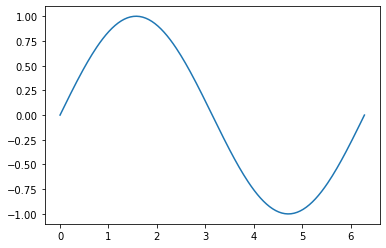

In [ ]:
# Example Print to check Numpy and MatPlotLib
x = np.linspace(0, 2 * np.pi, 200)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

In [ ]:
# Importing MNIST Dataset from Keras
from keras.datasets import mnist

### MNIST Dataset

The imported dataset  in the above code will look similar to the following :

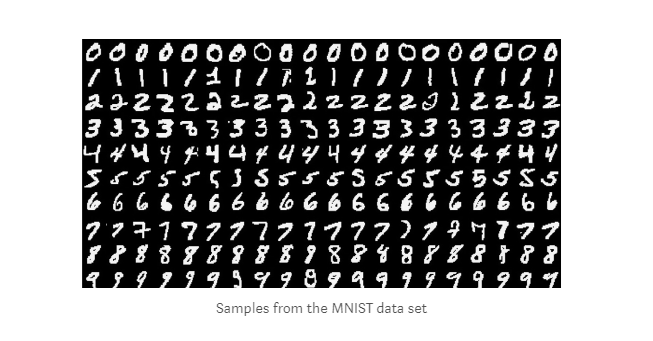

## Load and Preprocess the Dataset

We will need to load the required test and training dataset and preprocess them in order to get them to work in the network.

In [ ]:
# Initialise Variables with the Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Printing out training and test data shapes
print("Training Images : ", train_images.shape)
print("Training Labels : ", train_labels.shape)
print("\nTesting Images : ", test_images.shape)
print("Testing Labels : ", test_labels.shape)

11490434/11490434 [==============================] - 1s 0us/step
Training Images :  (60000, 28, 28)
Training Labels :  (60000,)

Testing Images :  (10000, 28, 28)
Testing Labels :  (10000,)


The dimensions of the dataset is 28 x 28 multiplied by the number of training/testing dataset. 

ex: Training Dimensions = 60000 x 28 x 28

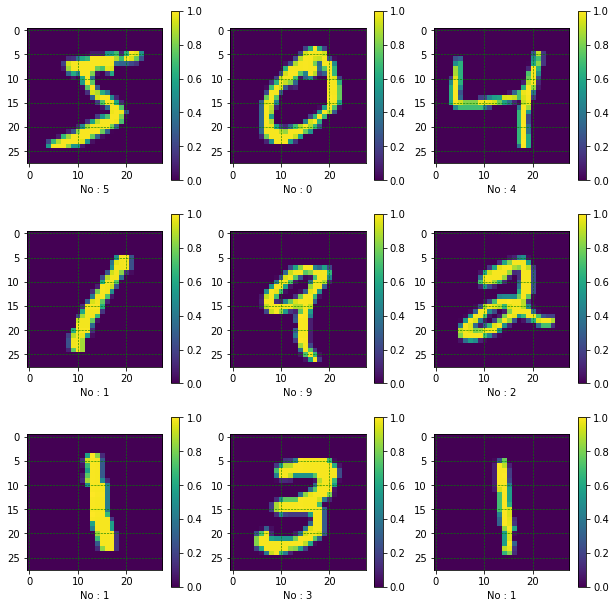

In [ ]:
# Condensing all values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Plotting the Dataset and Printing
plt.figure(figsize=(8,8))
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.grid(True)
  plt.grid(color = 'green', linestyle = '--', linewidth = 0.6)
  plt.imshow(train_images[i])
  plt.subplots_adjust(wspace=0.2, hspace=0.2, left=0, right=1, bottom=0, top=1)
  plt.xlabel(f"No : {train_labels[i]}")
  plt.colorbar()
plt.show()

Condensed to 0-1, once Printed, this should look like the following : 

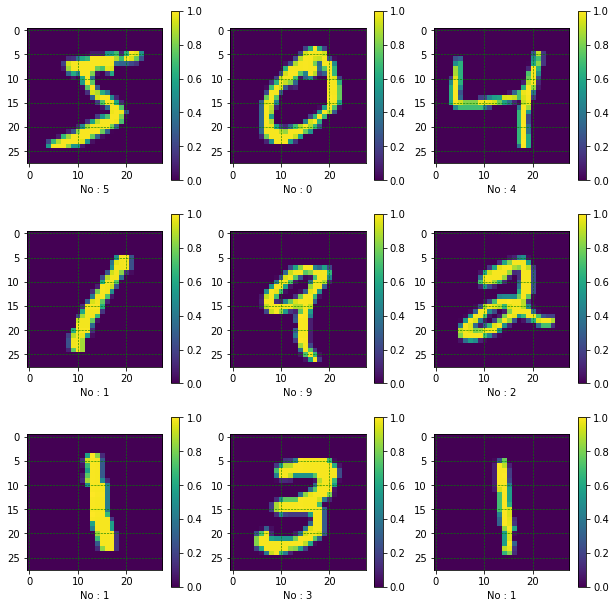

## Pre-processing the Vectors

In [ ]:
# Flattening the Image Data
print("Before Flattening : ", train_images.shape)
flatten_train_images = train_images.flatten().reshape(60000, 784)
print("After Flattening : ", flatten_train_images.shape)

Before Flattening :  (60000, 28, 28)
After Flattening :  (60000, 784)


## Defining the Neural Network

Here we create the neccessary classes to build and work with the neural network.

### Layers

We will create a called called DenseLayer which will hold all the operations of a layer in a neural network.

In [ ]:
class DenseLayer:

  def __init__(self, neurons):
    """
    Constructor
    """

    self.neurons = neurons

  def relu(self, inputs):
    """
    ReLU Activation Function
    """

    return np.maximum(0, inputs)

  def softmax(self, inputs):
    """
    SoftMax Activation Function
    """

    exp_scores = np.exp(inputs)
    probs =  exp_scores / np.sum(
        exp_scores,
        axis = 1,
        keepdims = True
        )
    return probs

  def relu_derivative(self, dA, Z):
    """
    ReLU Derivative Function
    """

    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

  def forward(self, inputs, weights, bias, activation):
    """
    Single Layer Forward Propagation
    """

    Z_curr = np.dot(inputs, weights.T) + bias

    if activation == "relu":
      A_curr = self.relu(inputs = Z_curr)
    elif activation == "softmax":
      A_curr = self.softmax(inputs = Z_curr)
    else:
      raise NotImplementedError

    return A_curr, Z_curr
  
  def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
    """
    Single Layer Backward Propagation
    """
    
    if activation == "softmax":
      dW = np.dot(A_prev.T, dA_curr)
      db = np.sum(dA_curr, axis = 0, keepdims = True)
      dA = np.dot(dA_curr, W_curr)
    # For all other activation functions - assuming it's relu derivative
    else:
      dZ = self.relu_derivative(dA_curr, Z_curr)
      dW = np.dot(A_prev.T, dZ)
      db = np.sum(dZ, axis = 0, keepdims = True)
      dA = np.dot(dZ, W_curr)
    
    return dA, dW, db



### Creating the Network Classes

Here we create a class called Network which contains all the functionality we need to work in the neural network.

In [ ]:
class Network:

  def __init__(self):
    self.network = [] #Layers
    self.architecture = [] #Mapping input neurons to output neurons
    self.params = [] #Weight and bias
    self.memory = [] #Z (dot product of input and weight + bias) and Activation
    self.gradients = [] #Differentiation of Weight and Differentiation of bias

  def add(self, layer):
    """
    Add layers to the network
    """
    self.network.append(layer)

  def _compile(self, data):
      """
      Initialize model architecture
      """
      for idx, layer in enumerate(self.network):

        # Input Layer
        if idx == 0:
          self.architecture.append({
              "input_dim": data.shape[1],
              "output_dim": self.network[idx].neurons,
              "activation": "relu"
          })

        # Hidden Layers
        elif idx > 0 and idx < len(self.network) - 1:
          self.architecture.append({
              "input_dim": self.network[idx-1].neurons,
              "output_dim": self.network[idx].neurons,
              "activation": "relu"
          })

        # Output Layer
        else:
          self.architecture.append({
              "input_dim": self.network[idx-1].neurons,
              "output_dim": self.network[idx].neurons,
              "activation": "softmax"
          })

      return self

  def _init_weights(self, data):
    """
    Initialize the model parameters
    """

    # Compiling the data first
    self._compile(data)

    # Reseed the singleton RandomState instance
    np.random.seed(99)

    for i in range(len(self.architecture)):
      self.params.append({
          # Weight
          'W':np.random.uniform(
              low = -1,
              high = 1,
              size=(
                  self.architecture[i]["output_dim"],
                  self.architecture[i]["input_dim"]
              )
          ),
          # Bias
          'b':np.zeros(
              (1, self.architecture[i]["output_dim"])
          )
      })

  def _forwardprop(self, data):
    """
    Performs one full forward pass through the network
    """

    A_curr = data

    for i in range(len(self.params)):
      A_prev = A_curr
      A_curr, Z_curr = self.network[i].forward(
          inputs = A_prev,
          weights = self.params[i]['W'],
          bias = self.params[i]['b'],
          activation = self.architecture[i]["activation"]
      )

      self.memory.append({
          "inputs": A_prev,
          'Z': Z_curr
      })

    return A_curr

  def _backprop(self, predicted, actual):
    """
    Performs on full backward pass through the network
    """
    
    # Get the number of samples in the labels array
    num_samples = len(actual)

    # Compute the Gradient on Predictions
    dscores = predicted
    dscores[range(num_samples), actual] -= 1
    dscores /= num_samples

    dA_prev = dscores

    for idx, layer in reversed(list(enumerate(self.network))):
      dA_curr = dA_prev

      A_prev = self.memory[idx]["inputs"]
      Z_curr = self.memory[idx]['Z']
      W_curr = self.params[idx]['W']

      activation = self.architecture[idx]["activation"]

      dA_prev, dW_curr, db_curr = layer.backward(
          dA_curr,
          W_curr,
          Z_curr,
          A_prev,
          activation
      )

      self.gradients.append({
          "dW": dW_curr,
          "db": db_curr
      })

  def _update(self, learn_rate=0.01):
    """
    Update the model parameters - learn_rate * gradient
    """
    
    for idx, layer in enumerate(self.network):
      self.params[idx]['W'] -= learn_rate * list(reversed(self.gradients))[idx]['dW'].T
      self.params[idx]['b'] -= learn_rate * list(reversed(self.gradients))[idx]['db']

  def _get_accuracy(self, predicted, actual):
    """
    Calculate accuracy after each iteration
    """
    
    return np.mean(np.argmax(predicted, axis = 1) == actual)

  def _calculate_loss(self, predicted, actual):
    """
    Calculate cross-entropy loss after each iteration
    """
    
    samples = len(actual)

    correct_logprobs = -np.log(predicted[range(samples), actual])
    data_loss = np.sum(correct_logprobs) / samples

    return data_loss

  def train(self, input_trains, input_labels, epochs, learn_rate = 0.01):
    """
    Train the model using SGD
    """
    
    self.loss = []
    self.accuracy = []

    # Initialise Weights
    self._init_weights(input_trains)

    for i in range(epochs):
      yhat = self._forwardprop(input_trains)
      self.accuracy.append(
          self._get_accuracy(
              predicted = yhat,
              actual = input_labels
          )
      )
      self.loss.append(
          self._calculate_loss(
              predicted = yhat,
              actual = input_labels
          )
      )

      self._backprop(
          predicted = yhat,
          actual = input_labels
      )

      self._update(learn_rate)

      # Print out the Epochs on their accuracy and loss levels
      if i % 5 == 0:
        print('EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(
              i, 
              self.accuracy[-1], 
              self.loss[-1]
              ))
      
    return self.loss, self.accuracy

## Training and Plotting the Actual Network

We will create the actual neural network and apply training to it and plot a graph to show how the accuracy and loss graphs change over the training period.

In [ ]:
# Generating the Neural Network
model = Network()

# Adding the Layers
model.add(DenseLayer(128))
model.add(DenseLayer(10))

# Running the Training using the Flattened Training Images
model_output = model.train(
    # Training Images
    flatten_train_images, 
    # Training Actual Outputs
    train_labels, 
    # Epochs
    51, 
    # Learning Rate
    0.01
    )

EPOCH: 0, ACCURACY: 0.09606666666666666, LOSS: 35.04866034908106
EPOCH: 5, ACCURACY: 0.11073333333333334, LOSS: 26.94132669250319
EPOCH: 10, ACCURACY: 0.12421666666666667, LOSS: 23.062571703955168
EPOCH: 15, ACCURACY: 0.1415, LOSS: 20.625323694964393
EPOCH: 20, ACCURACY: 0.16015, LOSS: 18.74832336791219
EPOCH: 25, ACCURACY: 0.18078333333333332, LOSS: 17.14131611695269
EPOCH: 30, ACCURACY: 0.20201666666666668, LOSS: 15.732796670943072
EPOCH: 35, ACCURACY: 0.22485, LOSS: 14.495153524864188
EPOCH: 40, ACCURACY: 0.24493333333333334, LOSS: 13.406431811392023
EPOCH: 45, ACCURACY: 0.26643333333333336, LOSS: 12.446544250403889
EPOCH: 50, ACCURACY: 0.2872, LOSS: 11.598543688660643


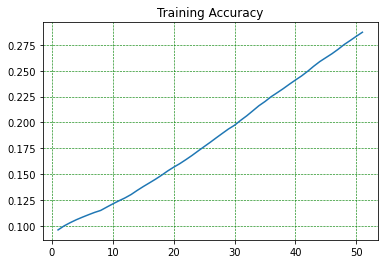

<Figure size 432x288 with 0 Axes>

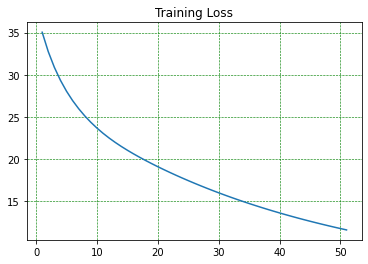

<Figure size 432x288 with 0 Axes>

In [ ]:
# Saving into variables
model_loss = model_output[0]
model_accuracy = model_output[1]
model_epochs = range(1, len(model_accuracy) + 1)

# Plotting the Accuracy Graph
plt.plot(model_epochs, model_accuracy, label = "Training Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.6)
plt.figure()
plt.show()

# Plotting the Loss Graph
plt.plot(model_epochs, model_loss, label = "Training Loss")
plt.title("Training Loss")
plt.grid(True)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.6)
plt.figure()
plt.show()

## Fine Tuning the Values

The trained model is not good enough because we see the curve is still going on without getting much flatter.

Let's tune it better. 

- Changing the Learning rate to 0.3
- Changing the Epoch Count to 65

In [ ]:
# Generating the Neural Network
model = Network()

# Adding the Layers
model.add(DenseLayer(128))
model.add(DenseLayer(10))

# Running the Training using the Flattened Training Images
model_output = model.train(
    # Training Images
    flatten_train_images, 
    # Training Actual Outputs
    train_labels, 
    # Epochs
    65, 
    # Learning Rate
    0.3
    )

EPOCH: 0, ACCURACY: 0.09606666666666666, LOSS: 35.04866034908106
EPOCH: 5, ACCURACY: 0.41575, LOSS: 13.892138583477188
EPOCH: 10, ACCURACY: 0.60905, LOSS: 3.809088701082711
EPOCH: 15, ACCURACY: 0.6893666666666667, LOSS: 2.444844542339643
EPOCH: 20, ACCURACY: 0.7291333333333333, LOSS: 1.9459947134871953
EPOCH: 25, ACCURACY: 0.7549333333333333, LOSS: 1.6893349382017588
EPOCH: 30, ACCURACY: 0.7726833333333334, LOSS: 1.5464890274294734
EPOCH: 35, ACCURACY: 0.7847833333333334, LOSS: 1.4325841023054549
EPOCH: 40, ACCURACY: 0.79485, LOSS: 1.3475759850138866
EPOCH: 45, ACCURACY: 0.80385, LOSS: 1.2751607167157966
EPOCH: 50, ACCURACY: 0.8110666666666667, LOSS: 1.2145151394126985
EPOCH: 55, ACCURACY: 0.8180333333333333, LOSS: 1.1615464436266056
EPOCH: 60, ACCURACY: 0.82405, LOSS: 1.1148122009768442


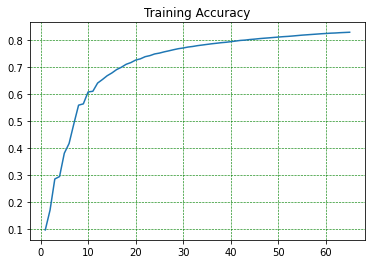

<Figure size 432x288 with 0 Axes>

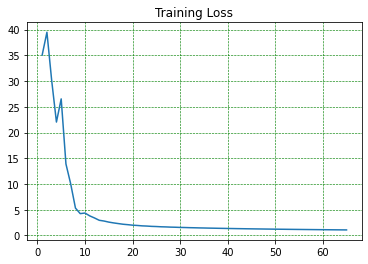

<Figure size 432x288 with 0 Axes>

In [ ]:
# Saving into variables
model_loss = model_output[0]
model_accuracy = model_output[1]
model_epochs = range(1, len(model_accuracy) + 1)

# Plotting the Accuracy Graph
plt.plot(model_epochs, model_accuracy, label = "Training Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.6)
plt.figure()
plt.show()

# Plotting the Loss Graph
plt.plot(model_epochs, model_loss, label = "Training Loss")
plt.title("Training Loss")
plt.grid(True)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.6)
plt.figure()
plt.show()

Comparing the two graphs, we can see that it has definitely improved.

Old -

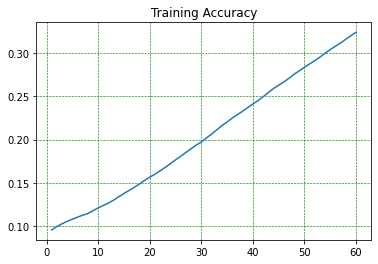

New - 

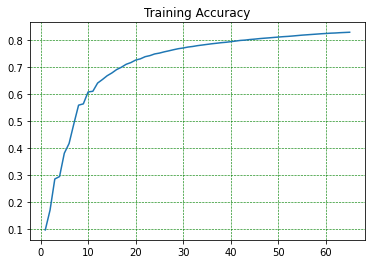